# Setup





In [122]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import math
import os

# Loading and exploring the data

In [123]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

def explore_data(data):
    print(data.head())
    print(data.describe().T)
    print(data.info())

# Visualizing the data

In [124]:
def plot_histograms(df):
    df.hist(bins=15, figsize=(15, 10))
    plt.show()

def graficar_boxplots_numericos(df):
    num_cols = df.select_dtypes(include=np.number).columns
    n_cols = 3  # número de columnas en la cuadrícula
    n_rows = math.ceil(len(num_cols) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.boxplot(x=df[col], ax=axes[i], color='lightcoral')
        axes[i].set_title(col)
        axes[i].set_xlabel("")
        
    # Ocultar subplots vacíos (si hay más espacios que columnas)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def graficar_distribucion_target(df):
    # Distribución de la variable objetivo (Emotion)
    if "Class" in df.columns:
        sns.countplot(
        x="Class",
        data=df,
        order=df["Class"].value_counts().index,
        palette="viridis"
        )
    plt.title("Distribución de clases (variable objetivo)")
    plt.xlabel("Clase")
    plt.ylabel("Número de registros")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def graficar_correlaciones(df):
    num_cols = df.select_dtypes(include=np.number).columns
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot=False)
    plt.title("Matriz de correlación (numéricas)")
    plt.show()

# Preprocessing

In [125]:
def resumen_valores_nulos(df: pd.DataFrame, top: int = None) -> pd.DataFrame:
    """
    Genera un resumen de valores nulos y vacíos en un DataFrame.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame a analizar.
    top : int, opcional
        Número máximo de filas a mostrar (por defecto muestra todas).

    Retorna:
    --------
    pd.DataFrame
        DataFrame con el conteo y porcentaje de valores nulos por columna.
    """
    missing = df.isna().sum().sort_values(ascending=False)
    missing_pct = (df.isna().sum() / len(df) * 100).round(2)

    resumen = pd.DataFrame({
        "Nulos": missing,
        "%": missing_pct
    })

    if top:
        resumen = resumen.head(top)

    print(f"🔍 Columnas con valores nulos: {(resumen['Nulos'] > 0).sum()} de {len(df.columns)} totales")
    return resumen

def limpiar_columnas_numericas(df: pd.DataFrame, exclude_cols: list = None) -> pd.DataFrame:
    """
    Limpia todas las columnas numéricas de un DataFrame:
    - Elimina espacios en blanco.
    - Reemplaza valores textuales no válidos por NaN.
    - Convierte a tipo numérico.
    - Imputa valores NaN con la mediana.
    Excluye las columnas especificadas en exclude_cols.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame a limpiar.
    exclude_cols : list, opcional
        Lista de columnas que se deben excluir del proceso (por defecto None).

    Retorna
    -------
    pd.DataFrame
        DataFrame limpio con columnas numéricas corregidas.
    """
    exclude_cols = exclude_cols or []
    df_clean = df.copy()

    for col in df_clean.columns:
        # Saltar columnas excluidas
        if col in exclude_cols:
            continue

        # Convertir valores a string y limpiar espacios
        df_clean[col] = df_clean[col].astype(str).str.strip()

        # Reemplazar textos no válidos por NaN
        df_clean[col] = df_clean[col].replace(
            ["error", "nan", "NaN", "None", "", "?", "undefined"], np.nan
        )

        # Convertir a numérico (forzando NaN donde no se pueda)
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

    # Imputar NaN con la mediana (solo numéricas)
    df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

    print(f"✅ Limpieza aplicada. Columnas excluidas: {exclude_cols}")
    print(f"🔹 Nulos restantes: {df_clean.isna().sum().sum()}")
    return df_clean

def eliminar_nulos_en_columna(df: pd.DataFrame, columna: str) -> pd.DataFrame:
    """
    Elimina las filas que tienen valores nulos en una columna específica
    y muestra cuántos registros se eliminaron.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame sobre el cual se eliminarán los valores nulos.
    columna : str
        Nombre de la columna en la cual se eliminarán los valores nulos.

    Retorna
    -------
    pd.DataFrame
        DataFrame sin las filas con valores nulos en la columna especificada.
    """
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    
    n_antes = df[columna].isna().sum()
    total_filas_antes = len(df)

    print(f"🔍 Valores nulos en '{columna}' antes: {n_antes}")

    # Eliminar filas con NaN en la columna especificada
    df_limpio = df.dropna(subset=[columna])

    n_despues = df_limpio[columna].isna().sum()
    filas_eliminadas = total_filas_antes - len(df_limpio)

    print(f"✅ Filas eliminadas: {filas_eliminadas}")
    print(f"🔹 Valores nulos en '{columna}' después: {n_despues}")
    return df_limpio

def aplicar_capping_outliers(df: pd.DataFrame, factor: float = 1.5) -> tuple[pd.DataFrame, dict]:
    """
    Aplica el método IQR (Interquartile Range) para limitar los outliers (capping)
    en todas las columnas numéricas de un DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame a procesar.
    factor : float, opcional
        Multiplicador del rango intercuartílico (por defecto 1.5).
        Valores más altos suavizan menos (dejan más outliers).

    Retorna
    -------
    tuple
        (df_modificado, estadisticas)
        df_modificado : DataFrame con outliers limitados.
        estadisticas : diccionario con información por columna.
    """
    df_capped = df.copy()
    stats = {}

    # Seleccionar columnas numéricas
    num_cols = df_capped.select_dtypes(include=np.number).columns

    for col in num_cols:
        s = df_capped[col]
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - factor * iqr, q3 + factor * iqr

        # Contar outliers antes del recorte
        n_outliers = ((s < low) | (s > high)).sum()

        # Aplicar clipping
        df_capped[col] = s.clip(lower=low, upper=high)

        stats[col] = {
            "Q1": round(q1, 4),
            "Q3": round(q3, 4),
            "LowLimit": round(low, 4),
            "HighLimit": round(high, 4),
            "OutliersRecortados": int(n_outliers)
        }

    print(f"✅ Capping de outliers aplicado en {len(num_cols)} columnas numéricas.")
    return df_capped, stats

def normalizar_columna_categorica(df: pd.DataFrame, columna: str) -> pd.DataFrame:
    """
    Normaliza los valores de una columna categórica:
    - Convierte todo a tipo string.
    - Elimina espacios en blanco al inicio y final.
    - Convierte todo a minúsculas.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene la columna a normalizar.
    columna : str
        Nombre de la columna categórica a limpiar.

    Retorna
    -------
    pd.DataFrame
        DataFrame con la columna normalizada.
    """
    if columna not in df.columns:
        raise ValueError(f"⚠️ La columna '{columna}' no existe en el DataFrame.")
    
    df[columna] = (
        df[columna]
        .astype(str)
        .str.strip()
        .str.lower()
    )

    print(f"✅ Columna '{columna}' normalizada (espacios y mayúsculas corregidos).")
    return df

# Comparar csv

In [140]:
def comparar_data_Frame(df, df_original):
    print("Dimensiones del original:", df_original.shape)
    print("Dimensiones del procesado:", df.shape)
    cols_original = set(df_original.columns)
    cols_clean = set(df.columns)

    print("Columnas eliminadas:", cols_original - cols_clean)
    print("Columnas nuevas:", cols_clean - cols_original)
    # Detectar columnas que están en el limpio pero no en el original
    cols_extra = list(set(df.columns) - set(df_original.columns))

    if cols_extra:
        df = df.drop(columns=cols_extra)
        print(f"✅ Columnas eliminadas: {cols_extra}")
    else:
        print("🔹 No hay columnas extra para eliminar.")
    
    return df

def comparar_tipos_datos(df, df_original):
    dtype_diff = pd.DataFrame({
    "Antes": df_original.dtypes,
    "Después": df.dtypes
    })
    dtype_diff = dtype_diff[dtype_diff["Antes"] != dtype_diff["Después"]]
    print("Columnas con cambio de tipo de dato:")
    print(dtype_diff)

def comparar_estadisticas(df, df_original):
    # Comparar estadísticas descriptivas
    summary_raw = df_original.describe()
    summary_clean = df.describe()

    # Combinar promedios para comparar
    comparison = pd.DataFrame({
        "Media (raw)": summary_raw.loc["mean"],
        "Media (clean)": summary_clean.loc["mean"],
        "Diferencia": summary_clean.loc["mean"] - summary_raw.loc["mean"]
    })
    print( comparison)


In [142]:
# Main function for running the pipeline
def main(filepath, filepathOriginal):
    data = load_data(filepath)
    explore_data(data)
    resumen_valores_nulos(data)
    exclude = ["Class"]
    data_clean = limpiar_columnas_numericas(data, exclude_cols=exclude)
    data_clean = eliminar_nulos_en_columna(data_clean, "Class")
    graficar_boxplots_numericos(data_clean)
    plot_histograms(data_clean)
    data_clean, outlier_stats = aplicar_capping_outliers(data_clean)
    graficar_boxplots_numericos(data_clean)
    plot_histograms(data_clean)
    graficar_distribucion_target(data_clean)
    data_clean = normalizar_columna_categorica(data_clean, "Class")
    graficar_distribucion_target(data_clean)
    graficar_correlaciones(data_clean)
    #Comparar
    dataOriginal = load_data(filepathOriginal)
    data_clean = comparar_data_Frame(data_clean,  dataOriginal)
    comparar_tipos_datos(data_clean, dataOriginal)
    comparar_estadisticas(data_clean, dataOriginal)
    

# Main function for running the pipeline

   Class _RMSenergy_Mean  _Lowenergy_Mean  _Fluctuation_Mean _Tempo_Mean  \
0  relax           0.052              NaN              9.136     130.043   
1  relax           0.125            0.439              6.680      142.24   
2  relax           0.046            0.639             10.578     188.154   
3  relax           0.135            0.603             10.442      65.991   
4  relax           0.066            0.591              9.769       88.89   

   _MFCC_Mean_1  _MFCC_Mean_2 _MFCC_Mean_3 _MFCC_Mean_4 _MFCC_Mean_5  ...  \
0         3.997         0.363        0.887        0.078        0.221  ...   
1         4.058         0.516        0.785        0.397        0.556  ...   
2         2.775         0.903        0.502        0.329        0.287  ...   
3         2.841         1.552        0.612        0.351        0.011  ...   
4         3.217         0.228        0.814        0.096        0.434  ...   

  _Chromagram_Mean_10 _Chromagram_Mean_11 _Chromagram_Mean_12  \
0              

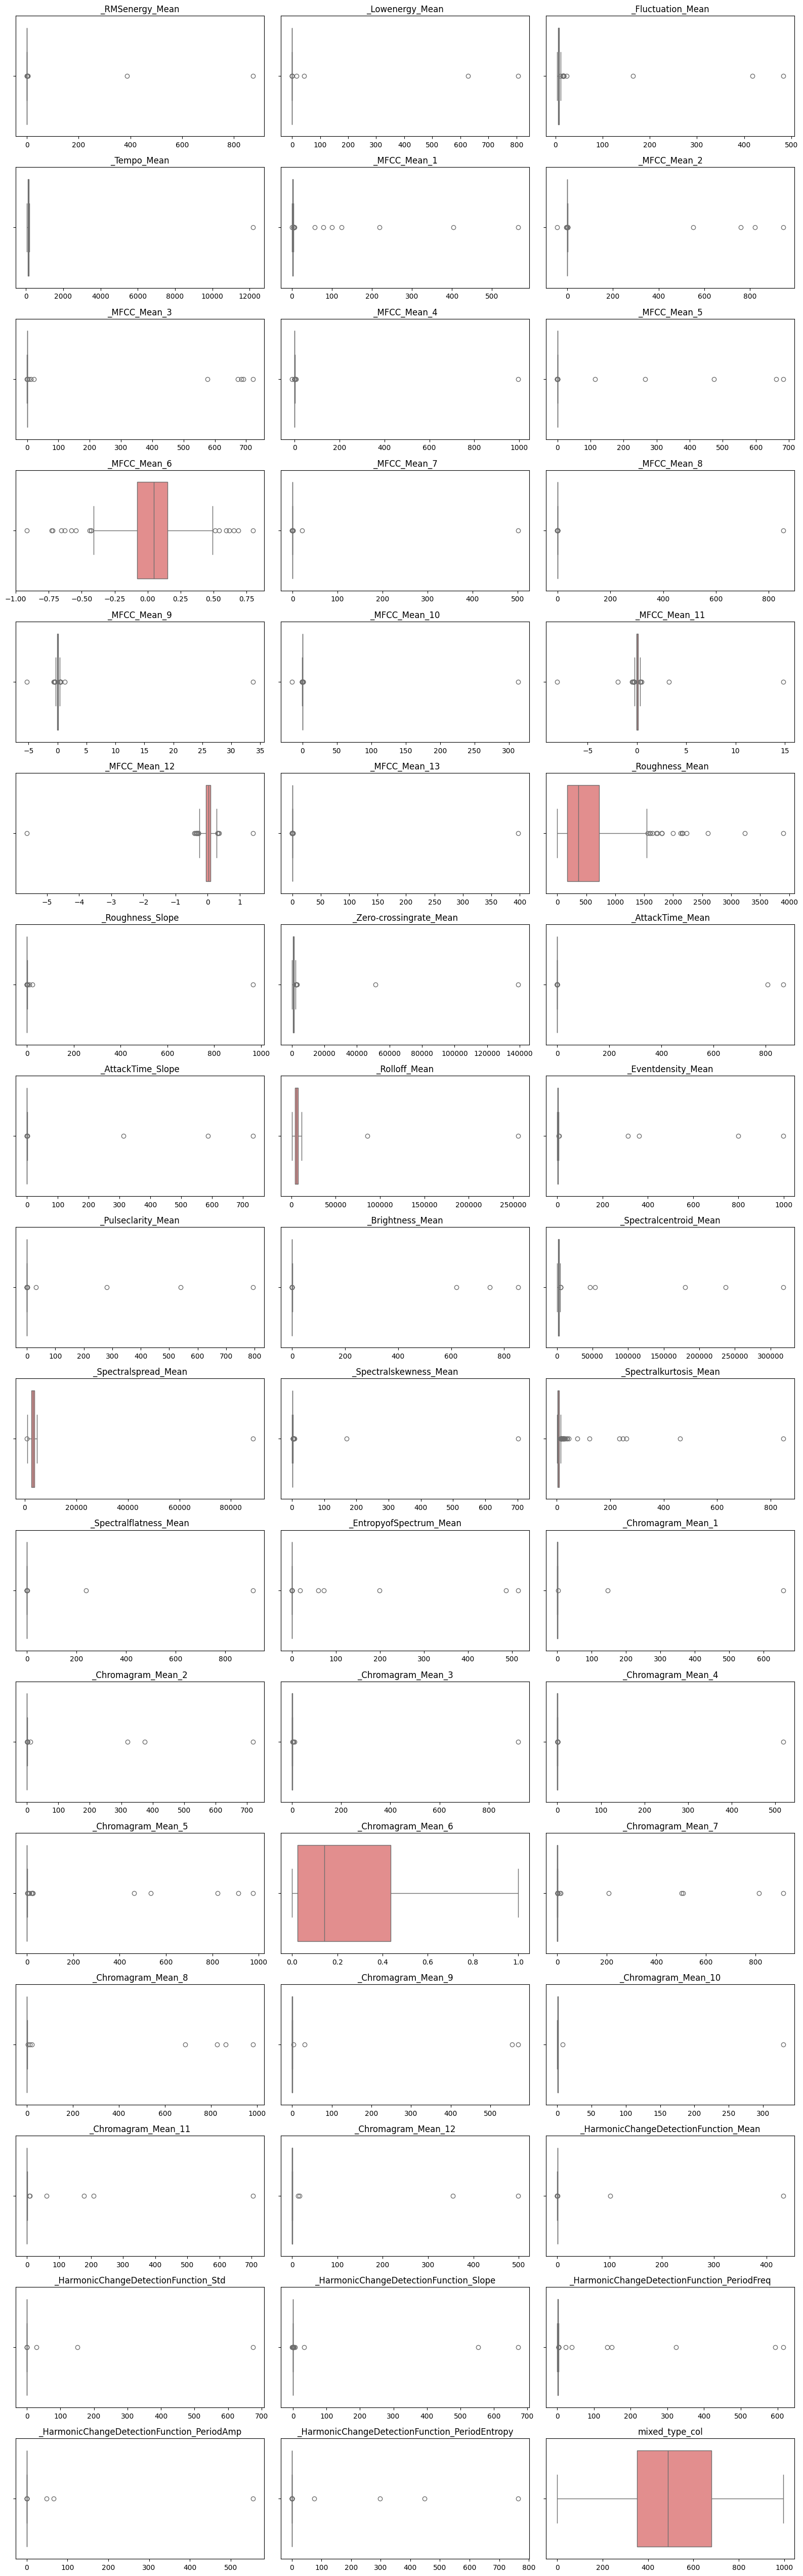

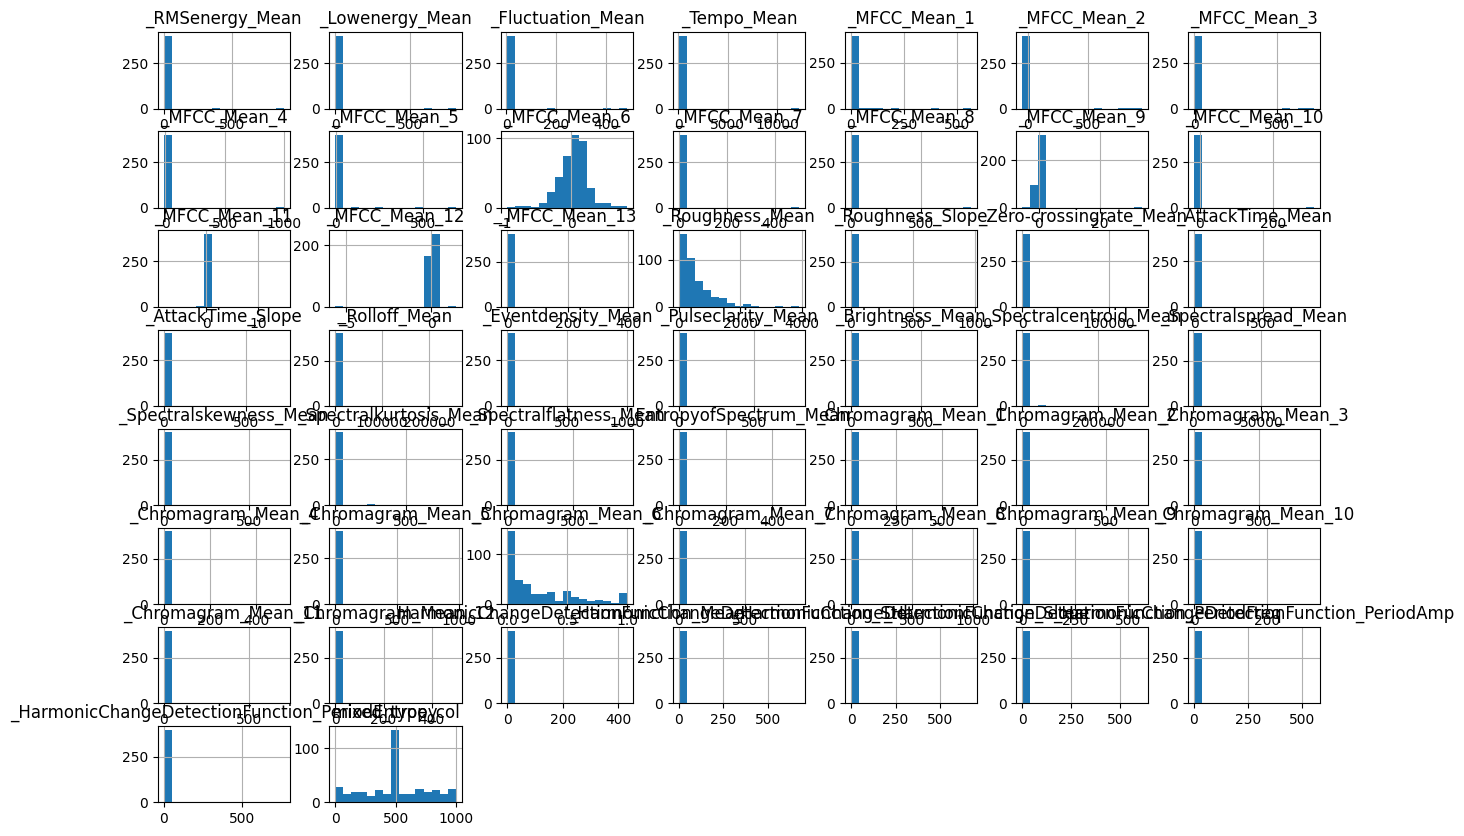

✅ Capping de outliers aplicado en 51 columnas numéricas.


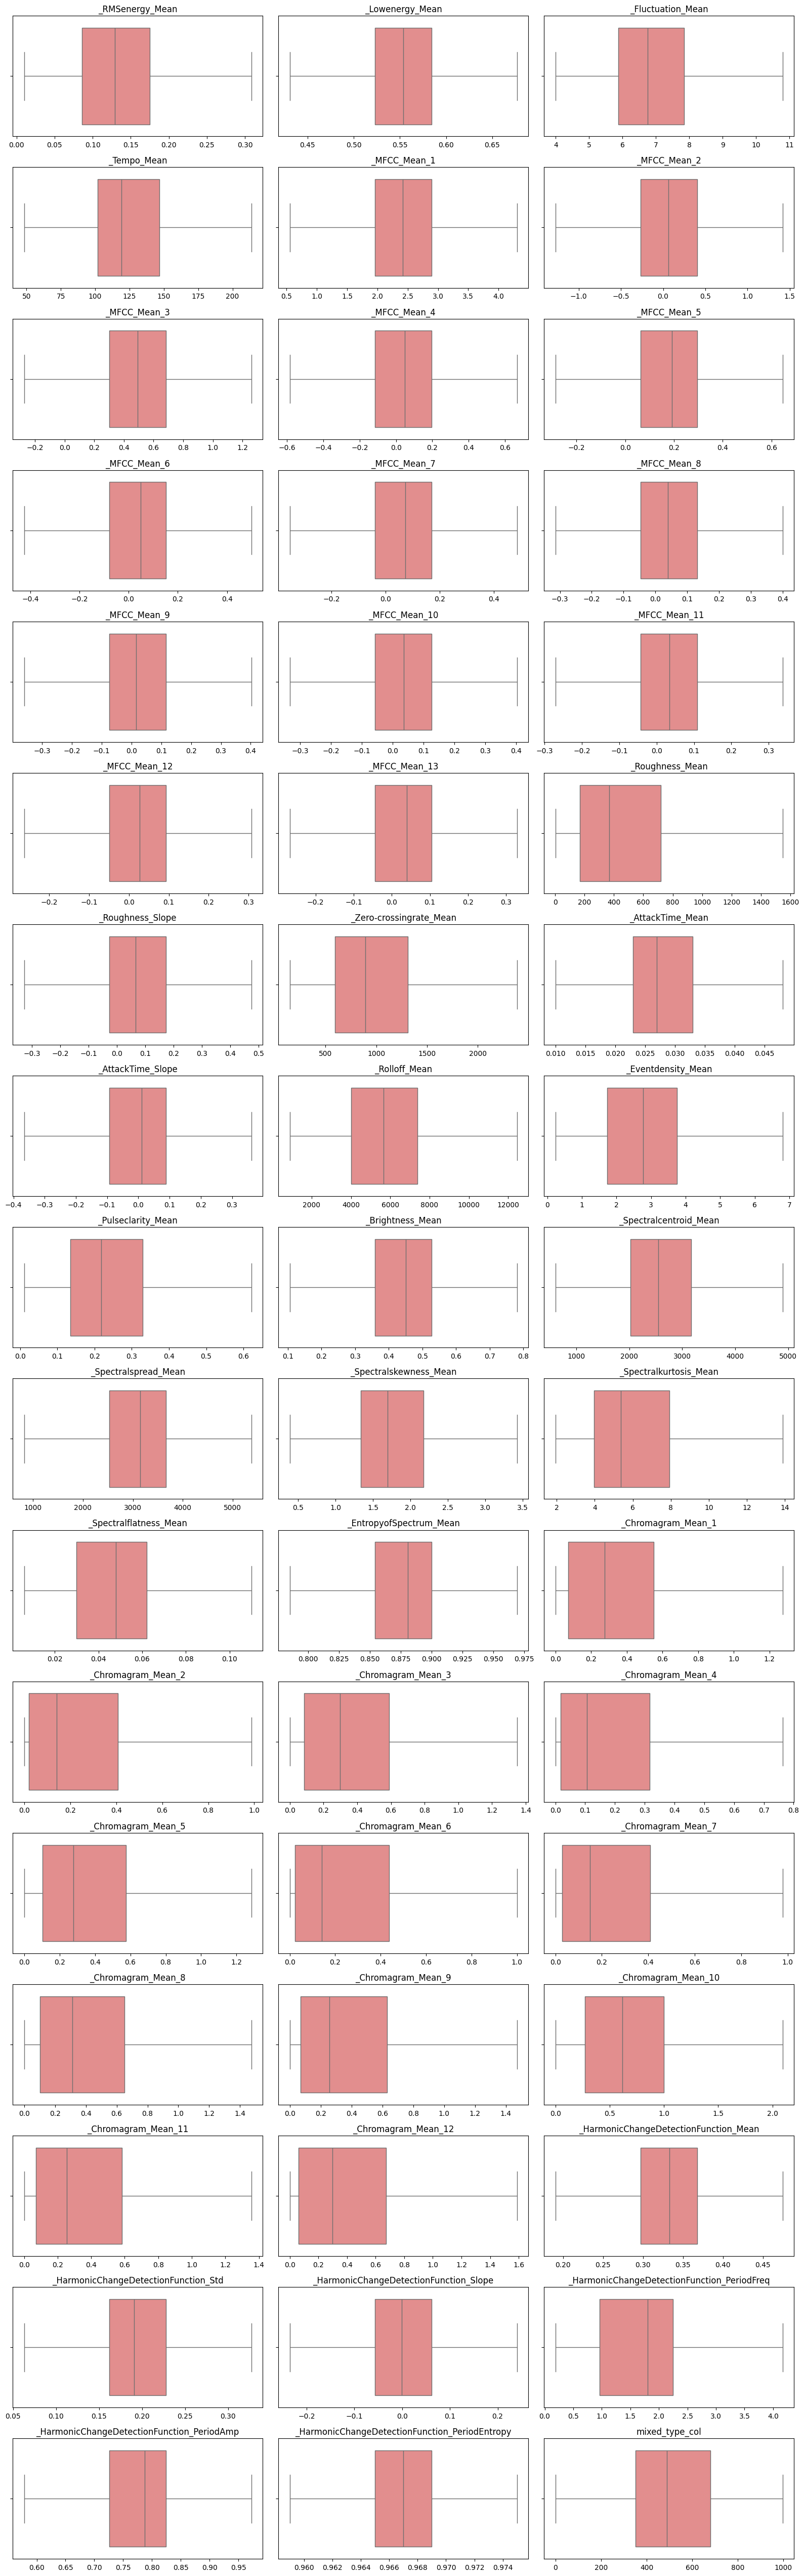

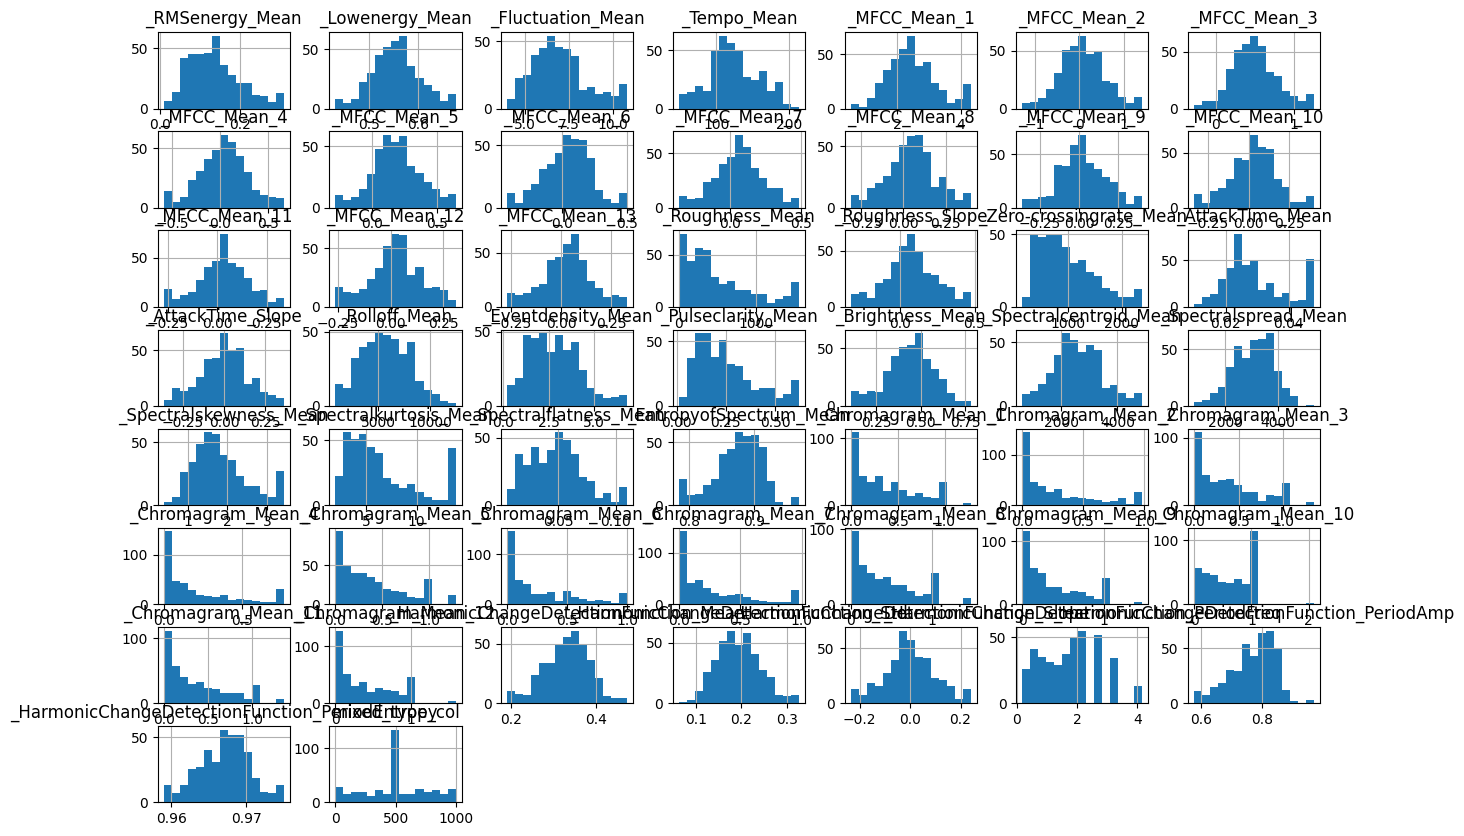

/var/folders/wg/3qzb2__s3wqcshs778xdqhpw0000gn/T/ipykernel_7585/255057197.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


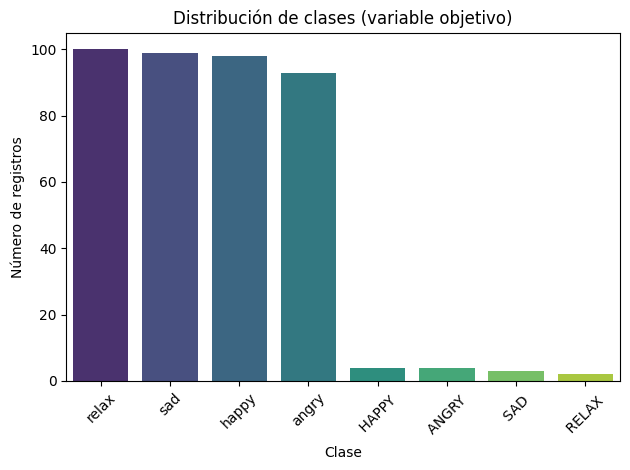

✅ Columna 'Class' normalizada (espacios y mayúsculas corregidos).


/var/folders/wg/3qzb2__s3wqcshs778xdqhpw0000gn/T/ipykernel_7585/255057197.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


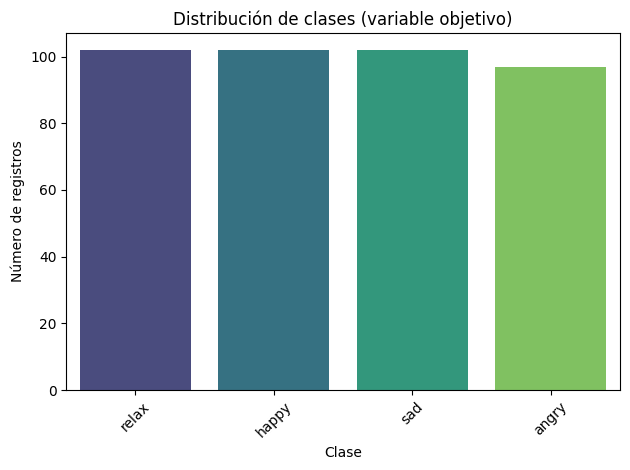

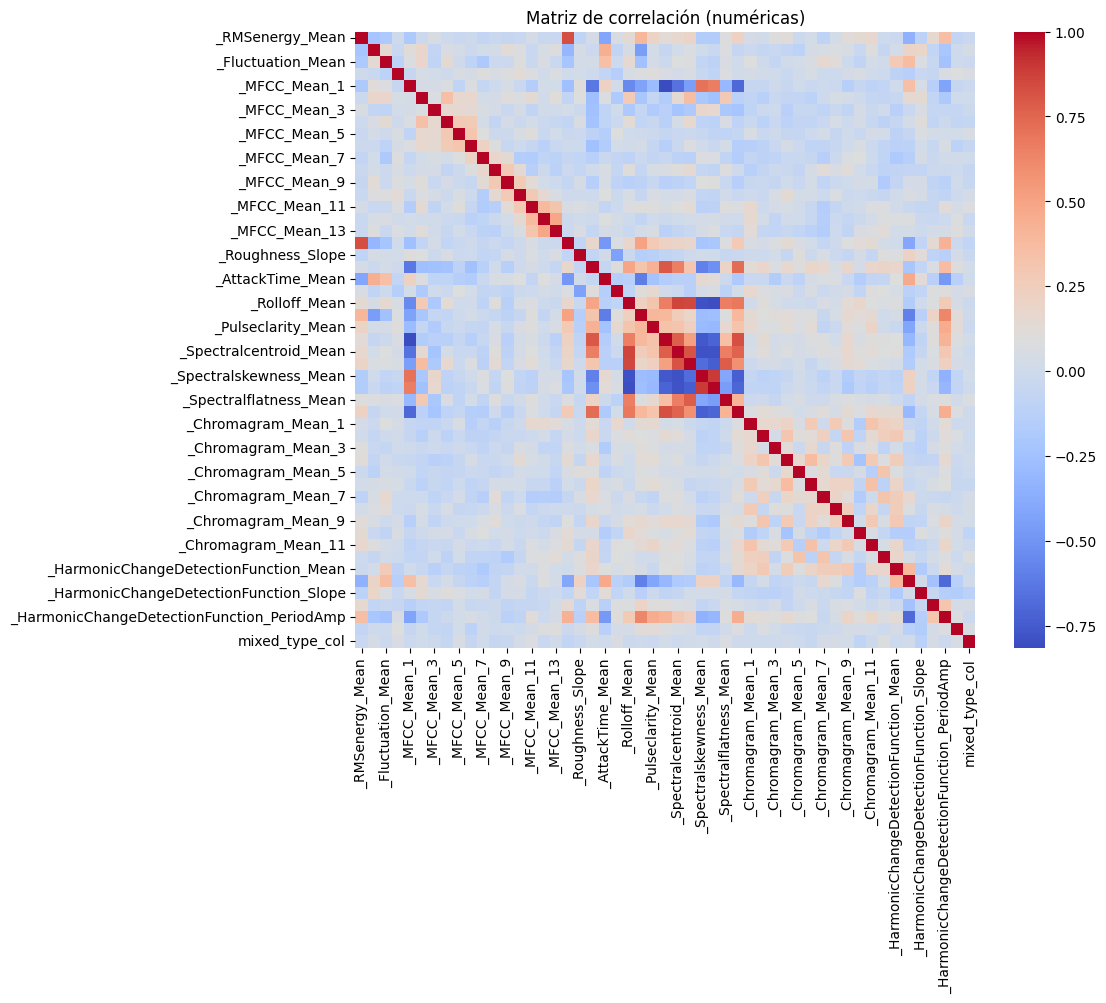

Dimensiones del original: (400, 51)
Dimensiones del procesado: (403, 52)
Columnas eliminadas: set()
Columnas nuevas: {'mixed_type_col'}
✅ Columnas eliminadas: ['mixed_type_col']
Columnas con cambio de tipo de dato:
Empty DataFrame
Columns: [Antes, Después]
Index: []
                                                Media (raw)  Media (clean)  \
_RMSenergy_Mean                                    0.134650       0.136912   
_Lowenergy_Mean                                    0.553605       0.555318   
_Fluctuation_Mean                                  7.145932       6.991819   
_Tempo_Mean                                      123.682020     123.454350   
_MFCC_Mean_1                                       2.456422       2.477726   
_MFCC_Mean_2                                       0.071890       0.077712   
_MFCC_Mean_3                                       0.488065       0.502868   
_MFCC_Mean_4                                       0.030465       0.035677   
_MFCC_Mean_5                   

In [143]:
main(filepath='../data/turkish_music_emotion_modified.csv', filepathOriginal='../data/turkis_music_emotion_original.csv' )